In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pygem_eb.processing.plotting_fxns import *
from objectives import *

       kice: 1.5    ksnow: 0.4    aice: 0.4
0.14890859353449806 0.5367902441081424
0.2852088511643396 0.596107495964474
0.22927362042257057 1.2096384857191487
       kice: 1.5    ksnow: 0.5    aice: 0.4
0.1481877195121834 0.5521845374699986
0.2831749929815614 0.5838179726206809
0.2325243872895151 1.2098769510487704
       kice: 1.5    ksnow: 0.6    aice: 0.4
0.1480228542433011 0.5647441530111597
0.28412507778855545 0.5760732921314543
0.23151318988624464 1.1966551240028085
       kice: 2    ksnow: 0.4    aice: 0.4
/home/claire/research/Output/calibration/09_17/kice2_ksnow0.4_aice0.4_siteAB_0.nc does not exist
/home/claire/research/Output/calibration/09_17/kice2_ksnow0.4_aice0.4_siteB_0.nc does not exist
/home/claire/research/Output/calibration/09_17/kice2_ksnow0.4_aice0.4_siteD_0.nc does not exist
       kice: 2    ksnow: 0.5    aice: 0.4
/home/claire/research/Output/calibration/09_17/kice2_ksnow0.5_aice0.4_siteAB_0.nc does not exist
/home/claire/research/Output/calibration/09_17/kice2_

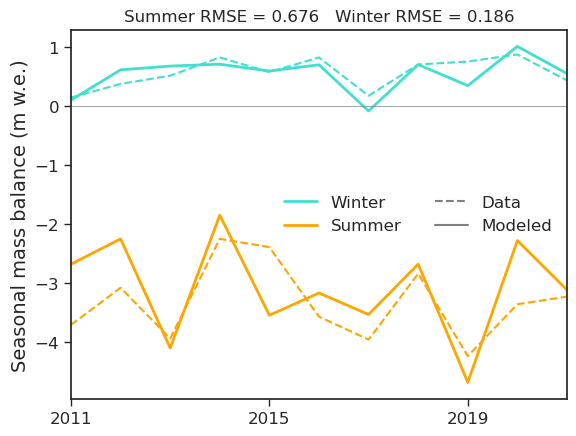

In [18]:
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
path_out = '/home/claire/research/Output/calibration/09_17/'
plot_site = 'AB'
aa = [0.4,0.5,0.6]
kkii = [1.5,2,2.5]
kkss = [0.4,0.5,0.6]
params = np.array([aa,kkii,kkss])
winter_result = np.ones((3,len(aa),len(kkii),len(kkss)))
summer_result = np.ones((3,len(aa),len(kkii),len(kkss)))
site_avg_winter = np.ones((len(aa),len(kkii),len(kkss)))
site_avg_summer = np.ones((len(aa),len(kkii),len(kkss)))
label = []

for i,a_ice in enumerate(aa):
    for j,k_ice in enumerate(kkii):
        for k,k_snow in enumerate(kkss):
            print(f'       kice: {k_ice}    ksnow: {k_snow}    aice: {a_ice}')
            label.append(f'{path_out}kice{k_ice}_ksnow{k_snow}_aice{a_ice}_site{plot_site}_0.nc')
            for s,site in enumerate(['AB','B','D']):
                fn = f'{path_out}kice{k_ice}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
                try:
                    ds,startdate,enddate = getds(fn)
                    winter,summer = seasonal_mass_balance(data_fp,ds,site=site,method='MAE')
                    winter_result[s,i,j,k] = winter
                    summer_result[s,i,j,k] = summer
                except:
                    winter_result[s,i,j,k] = winter*1e6
                    summer_result[s,i,j,k] = summer*1e6
                    print(fn+' does not exist')
            site_avg_winter[i,j,k] = np.mean(winter_result[:,i,j,k])
            site_avg_summer[i,j,k] = np.mean(summer_result[:,i,j,k])
best_winter = np.argmin(site_avg_winter)
best_summer = np.argmin(site_avg_summer)

print(f'Best winter run for was '+label[best_winter])
print(f'Best summer run for was '+label[best_summer])
ds = xr.open_dataset(label[best_summer])
fig,ax = seasonal_mass_balance(data_fp,ds,site=plot_site,plot=True)
fig.suptitle(f'Best summer run between all sites, at site {plot_site}')
plt.savefig('/home/claire/research/Output/calibration/best_summer.png',dpi=200)

0.31938410126399275 1.3254640868778864


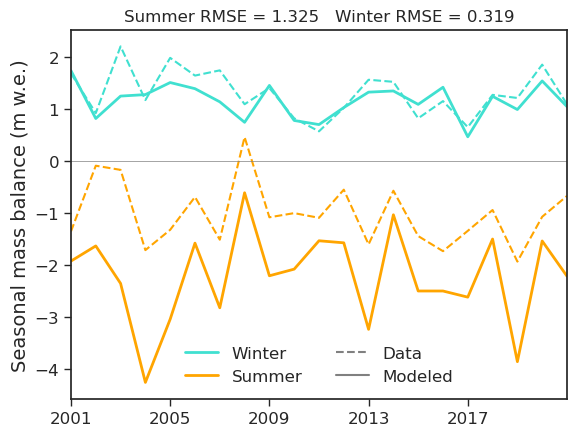

In [14]:
kicebest = 1.5
ksnowbest = 0.6
aicebest = 0.4
site = 'D'
ds = xr.open_dataset(f'/home/claire/research/Output/calibration/09_17/kice{kicebest}_ksnow{ksnowbest}_aice{aicebest}_site{site}_0.nc')

season = 'winter'
fig,ax = seasonal_mass_balance(data_fp,ds,site=site,plot=True)
plt.show()
# k = best[site][season].attrs['k_ice']
# a = best[site][season].attrs['a_ice']
# fig.suptitle(f'Best {season} run for {site} (a={a}, k={k})')
# plt.savefig(f'/home/claire/research/Output/calibration/best_{site}_{season}.png',dpi=150)
# print(k,a)

In [41]:
def plot_by(ds,bin,time,vars,t='Monthly EB Outputs',by='month'):
    h = 1.5
    fig,axes = plt.subplots(len(vars),1,figsize=(7,h*len(vars)),sharex=True,layout='constrained')
    if len(vars) == 1:
        axes = [axes]
    
    if by == 'month':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).month)
        time_list = np.arange(1,13)
    elif by == 'hour':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).hour)
        time_list = np.arange(0,24)
    elif by == 'doy':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).day_of_year)
        time_list = np.arange(1,366)

    if len(time) == 2:
        start = pd.to_datetime(time[0])
        end = pd.to_datetime(time[1])
        time = pd.date_range(start,end,freq='h')
    ds = ds.sel(time=time,bin=bin)
    c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    for i,v in enumerate(vars):
        axis = axes[i]
        vararray = np.array(v)
        for var in vararray:
            try:
                c = next(c_iter)
            except:
                c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
                c = next(c_iter)
        
            var_out = []
            for time in time_list:
                ds_sel = ds.where(ds[by] == time,drop=True)
                if 'layer' in var:
                    vardata = ds_sel.isel(layer=0)[var].to_numpy()
                else:
                    vardata = ds_sel[var].to_numpy()
                mean = np.mean(vardata)
                var_out.append(mean)
            axis.plot(time_list,var_out,label=var,color=c)
            axis.legend()
            if by == 'doy':
                axis.axvline(111,color='green')
                axis.axvline(294,color='red')
    if by == 'month':
        months = pd.date_range('2024-01-01','2024-12-31',freq='MS')
        month_names = [date.month_name()[:3] for date in months]
        axis.set_xticks(np.arange(1,13),month_names)
    if by == 'doy':
        axis.set_xlabel('Day of year')
    axis.set_ylabel('Melt (mm w.e.)')
    axis.tick_params(length=5)
    fig.suptitle(t)

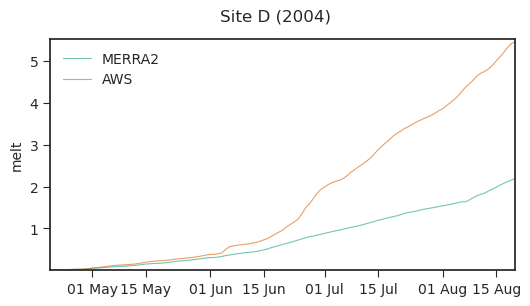

In [72]:
bin = 2
dslist = []
labels = []
ds_not,startdate,enddate = getds(f'~/research/Output/EB/a_0.1_k_0.5_0_bin{bin}.nc')
ds_AWS,startdate,enddate = getds(f'~/research/Output/EB/a_0.1_k_0.5_AWS_0_bin{bin}.nc')
dslist = [ds_not,ds_AWS]
labels = ['MERRA2','AWS']
compare_runs(dslist,0,['2004-04-20','2004-08-20'],['MERRA2','AWS'],'melt',t='Site D (2004)')

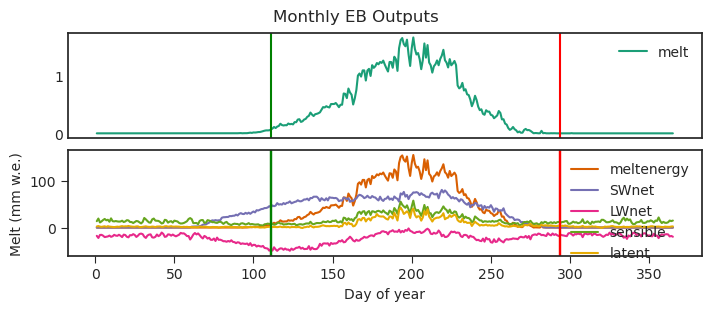

In [47]:

ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt'],['meltenergy','SWnet','LWnet','sensible','latent']],by='doy')

In [ ]:
ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt']],by='doy')